# Study notebook – Processament del dataset i figures

Aquest notebook:
1) Localitza automàticament la **root** del repositori `potato-dry-matter-optics-ml` i defineix rutes.
2) Carrega un dataset raw de dades mesurades al laboratori, es queda només amb unes columnes clau i elimina files amb NaN.
3) Calcula:
   - `MS_experimental` (mitjana de `MS2` i `MS3`)
   - `canal_NIR` (amb `nir_scalation(canal_NIR_raw, ref_NIR)`)
   - Mitjanes i desviacions RGB a partir del **crop** de la patata i el filtratge de colors extrems
4) Desa el dataset processat i genera figures d'estudi.

> ⚠️ Nota: `potato_pixels_rgb_img` fa servir Roboflow. Si no tens `ROBOFLOW_API_KEY` definit, la segmentació no funcionarà.


In [5]:
# Imports bàsics
import os
import sys
import re
import shutil
from pathlib import Path

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.auto import tqdm


In [6]:
# Definir rutes (ubicar-se a la root del projecte)
current_path = Path().resolve()
TARGET_ROOT_NAME = "potato-dry-matter-optics-ml"

while current_path.name != TARGET_ROOT_NAME and current_path.parent != current_path:
    current_path = current_path.parent

if current_path.name != TARGET_ROOT_NAME:
    raise RuntimeError(
        f"No s'ha trobat la carpeta '{TARGET_ROOT_NAME}' pujant des del directori actual: {Path().resolve()}"
    )

project_root = current_path
sys.path.append(str(project_root))

RUTA_DATASET = os.path.join(project_root, "data/input/raw/raw_dataset_definitive.csv")
RUTA_OUTPUT  = os.path.join(project_root, "data/input/processed/processed_dataset_definitive.csv")
IMAGES_ROOT = Path(project_root) / "data/input/raw/raw_images/definitive/"

# Carpeta on desarem figures
FIG_DIR = Path(project_root) / "data/output/study/study_definitive"
FIG_DIR.mkdir(parents=True, exist_ok=True)

# Preparar output (és un FITXER .csv, no un directori)
output_parent = Path(RUTA_OUTPUT).parent
output_parent.mkdir(parents=True, exist_ok=True)
if os.path.exists(RUTA_OUTPUT):
    os.remove(RUTA_OUTPUT)

print(f"Project root: {project_root}")
print(f"Dataset input: {RUTA_DATASET}")
print(f"Dataset output: {RUTA_OUTPUT}")
print(f"Figures dir: {FIG_DIR}")
print(f"Imatges dir: {IMAGES_ROOT}")

# Comprovar Roboflow API key (necessària per potato_pixels_rgb_img)
if "ROBOFLOW_API_KEY" not in os.environ:
    print("⚠️ ROBOFLOW_API_KEY no està definida. La segmentació amb Roboflow fallarà.")
    print("   Pots definir-la així (només en aquesta sessió):")
    print("   os.environ['ROBOFLOW_API_KEY'] = 'LA_TEVA_CLAU'")


Project root: D:\potato-dry-matter-optics-ml
Dataset input: D:\potato-dry-matter-optics-ml\data/input/raw/raw_dataset_definitive.csv
Dataset output: D:\potato-dry-matter-optics-ml\data/input/processed/processed_dataset_definitive.csv
Figures dir: D:\potato-dry-matter-optics-ml\data\output\study\study_definitive
Imatges dir: D:\potato-dry-matter-optics-ml\data\input\raw\raw_images\definitive


In [7]:
# Carregar el dataset (detecta automàticament separador i decimals)
def _detect_sep(path: str) -> str:
    first = Path(path).read_text(encoding="utf-8", errors="replace").splitlines()[0]
    return ";" if first.count(";") >= first.count(",") else ","

def _to_float_series(s: pd.Series) -> pd.Series:
    # Converteix valors amb coma decimal i possibles tabs/espais a float
    def _clean_one(x):
        if pd.isna(x):
            return np.nan
        if isinstance(x, (int, float, np.number)):
            return float(x)
        x = str(x).strip().replace("\t", "").replace(" ", "")
        if x == "" or x.lower() in {"nan", "none"}:
            return np.nan
        # canvia coma decimal -> punt
        x = x.replace(",", ".")
        # Manté només caràcters numèrics vàlids (inclou signe i exponent)
        x = re.sub(r"[^0-9eE\+\-\.]", "", x)
        try:
            return float(x)
        except Exception:
            return np.nan
    return s.map(_clean_one).astype(float)

sep = _detect_sep(RUTA_DATASET)
print(f"Separador detectat: {sep!r}")

df = pd.read_csv(
    RUTA_DATASET,
    sep=sep,
    engine="python",
    na_values=["", "NaN", "nan", "None"],
    keep_default_na=True,
)

# Columnes que volem conservar i exigir sense NaN
keep_cols = [
    "id_mostra",
    "ruta_imatges",
    "lot",
    "M_aire(g)",
    "M_aigua(g)",
    "ge",
    "MS2",
    "MS3",
    "h2",
    "densitat",
    "canal_NIR_raw",
    "ref_NIR",
    "y1_y2_norm",
]

missing = [c for c in keep_cols if c not in df.columns]
if missing:
    raise KeyError(f"Falten columnes al CSV: {missing}\nColumnes disponibles: {list(df.columns)}")

# Ens quedem només amb aquestes
df = df[keep_cols].copy()

# Conversions numèriques (totes menys ruta_imatges i lot)
num_cols = [c for c in keep_cols if c not in ("id_mostra", "ruta_imatges", "lot")]
for c in num_cols:
    df[c] = _to_float_series(df[c])

# id_mostra a index (enter si es pot)
df["id_mostra"] = _to_float_series(df["id_mostra"])
df = df.dropna(subset=["id_mostra"])
df["id_mostra"] = df["id_mostra"].astype(int)
df = df.set_index("id_mostra")

# Netejar strings
df["ruta_imatges"] = df["ruta_imatges"].astype(str).str.strip()
df["lot"] = df["lot"].astype(str).str.strip()

# Drop de files amb algun NaN a qualsevol de les columnes clau
before = len(df)
df = df.dropna(subset=keep_cols[1:])  # totes excepte id_mostra (ara index)
after = len(df)
print(f"Files abans: {before} | després de drop NaNs: {after} | eliminades: {before-after}")

print("\n=== INFORMACIÓ DEL DATASET (després de neteja inicial) ===\n")
display(df.head())
df.info()


Separador detectat: ','
Files abans: 155 | després de drop NaNs: 151 | eliminades: 4

=== INFORMACIÓ DEL DATASET (després de neteja inicial) ===



ruta_imatges lot  M_aire(g)  M_aigua(g)        ge        MS2  \
id_mostra                                                                
36            p3_1.png  L3     149.55         9.7  1.069360  17.964966   
37            p3_2.png  L3     145.00         9.9  1.073279  18.791880   
38            p3_3.png  L3      73.50         6.0  1.088889  22.085556   
39            p3_4.png  L3     225.00        19.2  1.093294  23.015131   
40            p3_5.png  L3      61.60         5.8  1.103943  25.261900   

                 MS3     h2  densitat  canal_NIR_raw  ref_NIR  y1_y2_norm  
id_mostra                                                                  
36         18.397932  18.15  1.180898        57198.0  14713.0    1.076408  
37         19.253005  18.00  1.316716        61995.0  21210.0    1.115290  
38         22.658840  17.40  1.668597        63410.0  24238.0    1.073677  
39         23.620071  18.70  1.201870        17912.0   4327.3    1.028609  
40         25.943348  17.20  2.796886        56508.0  17079.0    1.050272

<class 'pandas.core.frame.DataFrame'>
Index: 151 entries, 36 to 190
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   ruta_imatges   151 non-null    object 
 1   lot            151 non-null    object 
 2   M_aire(g)      151 non-null    float64
 3   M_aigua(g)     151 non-null    float64
 4   ge             151 non-null    float64
 5   MS2            151 non-null    float64
 6   MS3            151 non-null    float64
 7   h2             151 non-null    float64
 8   densitat       151 non-null    float64
 9   canal_NIR_raw  151 non-null    float64
 10  ref_NIR        151 non-null    float64
 11  y1_y2_norm     151 non-null    float64
dtypes: float64(10), object(2)
memory usage: 14.7+ KB


In [8]:
# Imports de funcions del projecte
# (assumim que existeixen a src/raw_image_treatment.py dins del repo)
try:
    from src.raw_image_treatment import nir_scalation, potato_pixels_rgb_img, potato_filter_extreme_colours
except Exception as e:
    raise ImportError(
        "No he pogut importar des de src.raw_image_treatment.\n"
        "Assegura't que estàs executant aquest notebook dins del repo i que existeix src/raw_image_treatment.py\n"
        f"Error original: {e}"
    )

# 1) MS_experimental: mitjana entre MS2 i MS3
df["MS_experimental"] = df[["MS2", "MS3"]].mean(axis=1)

# 2) canal_NIR: normalització/escala
df["canal_NIR"] = nir_scalation(df["canal_NIR_raw"].values, df["ref_NIR"].values)

# Paràmetres (pots ajustar-los si vols)
SEGMENT_MARGIN = 35      # marge d'erosió en potato_pixels_rgb_img
FILTER_MARGIN  = 40      # marge de tolerància per potato_filter_extreme_colours

def _rgb_mean_std_ignore_black(pil_img) -> tuple:
    arr = np.asarray(pil_img, dtype=np.uint8)
    if arr.ndim != 3 or arr.shape[2] != 3:
        raise ValueError(f"Imatge RGB esperada, però arr shape={arr.shape}")
    mask = np.any(arr != 0, axis=2)  # ignora píxels negres (0,0,0)
    if mask.sum() == 0:
        return (np.nan, np.nan, np.nan, np.nan, np.nan, np.nan)
    vals = arr[mask]  # (N,3)
    mean = vals.mean(axis=0)
    std  = vals.std(axis=0)
    return (*mean.tolist(), *std.tolist())

means_R, means_G, means_B = [], [], []
stds_R, stds_G, stds_B = [], [], []

failed = 0
for idx, row in tqdm(df.iterrows(), total=len(df), desc="Procesant imatges (RGB)"):
    img_rel = str(row["ruta_imatges"]).strip()
    img_path = IMAGES_ROOT / img_rel

    if not img_path.exists():
        failed += 1
        means_R.append(np.nan); means_G.append(np.nan); means_B.append(np.nan)
        stds_R.append(np.nan);  stds_G.append(np.nan);  stds_B.append(np.nan)
        continue

    cropped_img, _vis = potato_pixels_rgb_img(img_path, margin=SEGMENT_MARGIN)

    if cropped_img is None:
        failed += 1
        means_R.append(np.nan); means_G.append(np.nan); means_B.append(np.nan)
        stds_R.append(np.nan);  stds_G.append(np.nan);  stds_B.append(np.nan)
        continue

    filt_out = potato_filter_extreme_colours(cropped_img, margin=FILTER_MARGIN, ignore_black=True)

    # Compatibilitat: hi ha versions que retornen només la imatge, i altres (img, median_color)
    if isinstance(filt_out, tuple):
        filtered_img = filt_out[0]
    else:
        filtered_img = filt_out

    try:
        mR, mG, mB, sR, sG, sB = _rgb_mean_std_ignore_black(filtered_img)
    except Exception:
        failed += 1
        mR = mG = mB = sR = sG = sB = np.nan

    means_R.append(mR); means_G.append(mG); means_B.append(mB)
    stds_R.append(sR);  stds_G.append(sG);  stds_B.append(sB)

df["color_promig_R"] = means_R
df["color_promig_G"] = means_G
df["color_promig_B"] = means_B
df["desviació_R"] = stds_R
df["desviació_G"] = stds_G
df["desviació_B"] = stds_B

print(f"Files amb fallada (imatge no trobada / segmentació / càlcul): {failed}")

# Si vols assegurar-te que no queden NaNs en les noves features (recomanat per plots):
before2 = len(df)
df = df.dropna(subset=[
    "MS_experimental", "canal_NIR",
    "color_promig_R", "color_promig_G", "color_promig_B",
    "desviació_R", "desviació_G", "desviació_B",
])
after2 = len(df)
print(f"Drop NaNs extra (per features noves): {before2} -> {after2} (eliminades {before2-after2})")

display(df.head())


Procesant imatges (RGB): 100%|██████████| 151/151 [08:37<00:00,  3.43s/it]

Files amb fallada (imatge no trobada / segmentació / càlcul): 0
Drop NaNs extra (per features noves): 151 -> 151 (eliminades 0)


ruta_imatges lot  M_aire(g)  M_aigua(g)        ge        MS2  \
id_mostra                                                                
36            p3_1.png  L3     149.55         9.7  1.069360  17.964966   
37            p3_2.png  L3     145.00         9.9  1.073279  18.791880   
38            p3_3.png  L3      73.50         6.0  1.088889  22.085556   
39            p3_4.png  L3     225.00        19.2  1.093294  23.015131   
40            p3_5.png  L3      61.60         5.8  1.103943  25.261900   

                 MS3     h2  densitat  canal_NIR_raw  ref_NIR  y1_y2_norm  \
id_mostra                                                                   
36         18.397932  18.15  1.180898        57198.0  14713.0    1.076408   
37         19.253005  18.00  1.316716        61995.0  21210.0    1.115290   
38         22.658840  17.40  1.668597        63410.0  24238.0    1.073677   
39         23.620071  18.70  1.201870        17912.0   4327.3    1.028609   
40         25.943348  17.20  2.796886        56508.0  17079.0    1.050272   

           MS_experimental  canal_NIR  color_promig_R  color_promig_G  \
id_mostra                                                               
36               18.181449   3.887582      100.422562       71.011757   
37               19.022442   2.922914       93.638415       65.401514   
38               22.372198   2.616140       86.792229       58.882750   
39               23.317601   4.139302       84.438582       57.749934   
40               25.602624   3.308625       69.963137       48.435745   

           color_promig_B  desviació_R  desviació_G  desviació_B  
id_mostra                                                         
36              41.187936    22.923658    18.311081    12.131452  
37              38.536081    21.588104    17.058105    11.380226  
38              34.893185    22.018175    16.433455    10.579972  
39              37.216659    20.963172    15.657005    11.427459  
40              30.595482    19.281510    14.369099     9.855608

In [9]:
# Eliminar columnes que ja no volem
drop_cols = ["M_aire(g)", "M_aigua(g)", "ge", "MS2", "MS3", "h2", "canal_NIR_raw", "ref_NIR"]
df_final = df.drop(columns=drop_cols, errors="ignore").copy()

# Guardar
df_final.to_csv(RUTA_OUTPUT, index=True)
print(f"✅ Dataset processat guardat a: {RUTA_OUTPUT}")

display(df_final.head())
df_final.info()


✅ Dataset processat guardat a: D:\potato-dry-matter-optics-ml\data/input/processed/processed_dataset_definitive.csv


ruta_imatges lot  densitat  y1_y2_norm  MS_experimental  canal_NIR  \
id_mostra                                                                      
36            p3_1.png  L3  1.180898    1.076408        18.181449   3.887582   
37            p3_2.png  L3  1.316716    1.115290        19.022442   2.922914   
38            p3_3.png  L3  1.668597    1.073677        22.372198   2.616140   
39            p3_4.png  L3  1.201870    1.028609        23.317601   4.139302   
40            p3_5.png  L3  2.796886    1.050272        25.602624   3.308625   

           color_promig_R  color_promig_G  color_promig_B  desviació_R  \
id_mostra                                                                
36             100.422562       71.011757       41.187936    22.923658   
37              93.638415       65.401514       38.536081    21.588104   
38              86.792229       58.882750       34.893185    22.018175   
39              84.438582       57.749934       37.216659    20.963172   
40              69.963137       48.435745       30.595482    19.281510   

           desviació_G  desviació_B  
id_mostra                            
36           18.311081    12.131452  
37           17.058105    11.380226  
38           16.433455    10.579972  
39           15.657005    11.427459  
40           14.369099     9.855608

<class 'pandas.core.frame.DataFrame'>
Index: 151 entries, 36 to 190
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ruta_imatges     151 non-null    object 
 1   lot              151 non-null    object 
 2   densitat         151 non-null    float64
 3   y1_y2_norm       151 non-null    float64
 4   MS_experimental  151 non-null    float64
 5   canal_NIR        151 non-null    float32
 6   color_promig_R   151 non-null    float64
 7   color_promig_G   151 non-null    float64
 8   color_promig_B   151 non-null    float64
 9   desviació_R      151 non-null    float64
 10  desviació_G      151 non-null    float64
 11  desviació_B      151 non-null    float64
dtypes: float32(1), float64(9), object(2)
memory usage: 14.2+ KB


Columnes al pairplot: ['densitat', 'y1_y2_norm', 'MS_experimental', 'canal_NIR', 'color_promig_R', 'color_promig_G', 'color_promig_B', 'desviació_R', 'desviació_G', 'desviació_B']
Files pel pairplot: 151


The figure layout has changed to tight


✅ Pairplot guardat a: D:\potato-dry-matter-optics-ml\data\output\study\study_definitive\pairplot_all_features.png


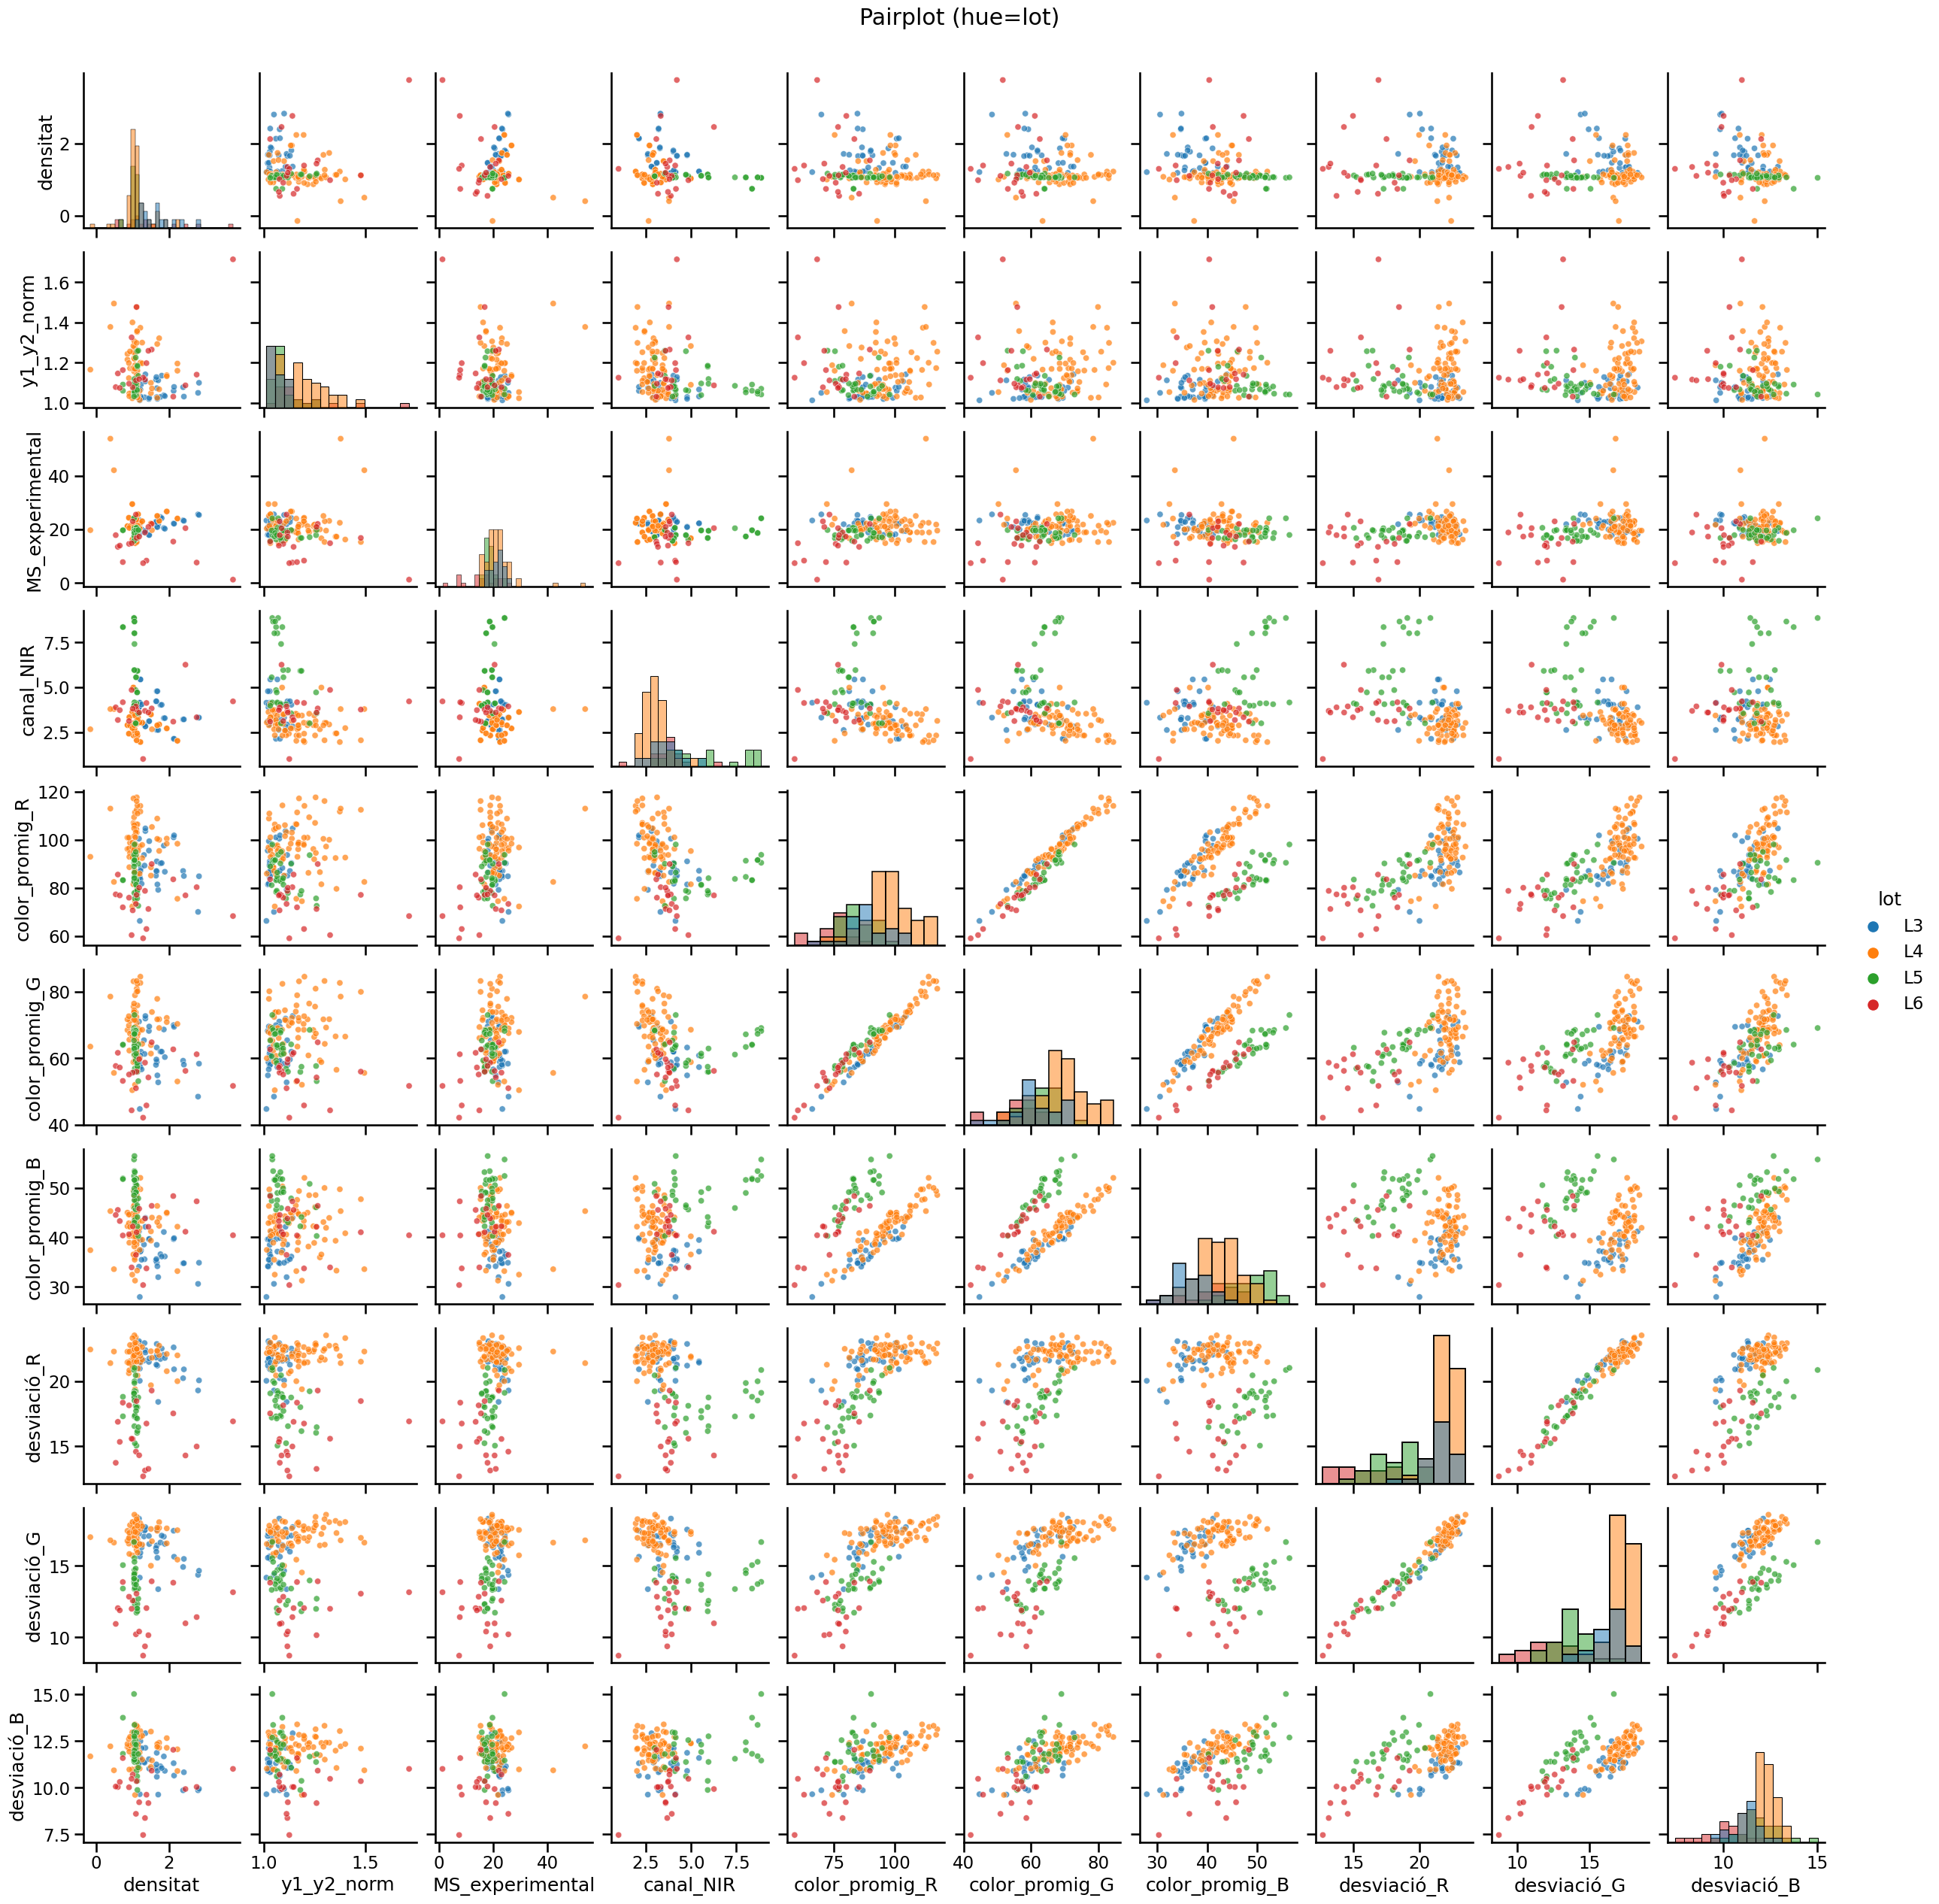

In [10]:
# Pairplot (totes les dades menys id_mostra i lot) amb color per lot
import numpy as np
import warnings

# --- 1) triar columnes a plotar (excloent lot i ruta_imattges) ----------
exclude = {"lot", "ruta_imattges", "ruta_imatges"}  # per si al df es diu diferent
vars_to_plot = [
    c for c in df_final.columns
    if c not in exclude and pd.api.types.is_numeric_dtype(df_final[c])
]

# --- 2) preparar dataframe per seaborn --------------------------------
pair_df = df_final[vars_to_plot + (["lot"] if "lot" in df_final.columns else [])].copy()

# Inf -> NaN (evita warnings i problemes)
pair_df = pair_df.replace([np.inf, -np.inf], np.nan)

# Drop NaNs només en el que realment es ploteja + hue
subset_cols = vars_to_plot + (["lot"] if "lot" in pair_df.columns else [])
pair_df = pair_df.dropna(subset=subset_cols)

print("Columnes al pairplot:", vars_to_plot)
print("Files pel pairplot:", len(pair_df))

sns.set_context("talk")

# --- 3) silenciar warnings molestos (opcional) ------------------------
warnings.filterwarnings("ignore", message="use_inf_as_na option is deprecated")
warnings.filterwarnings("ignore", message="When grouping with a length-1 list-like")

pair = sns.pairplot(
    data=pair_df,
    vars=vars_to_plot,
    hue="lot" if "lot" in pair_df.columns else None,
    corner=False,
    diag_kind="hist",
    plot_kws={"alpha": 0.7, "s": 35},
)

pair.fig.suptitle("Pairplot (hue=lot)", y=1.02)

pair_path = FIG_DIR / "pairplot_all_features.png"
pair.savefig(pair_path, dpi=200, bbox_inches="tight")
print(f"✅ Pairplot guardat a: {pair_path}")

plt.show()

✅ Figura guardada: D:\potato-dry-matter-optics-ml\data\output\study\study_definitive\ms_vs_colors_promig.png


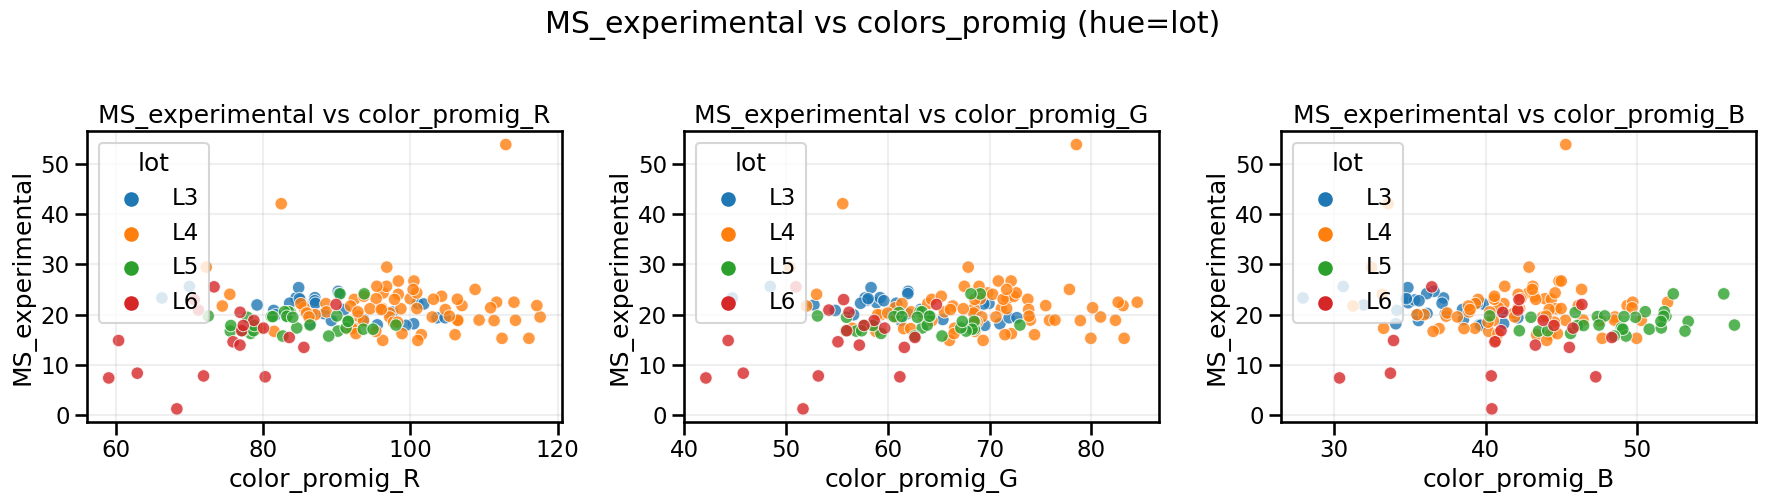

✅ Figura guardada: D:\potato-dry-matter-optics-ml\data\output\study\study_definitive\ms_vs_desviacions_rgb.png


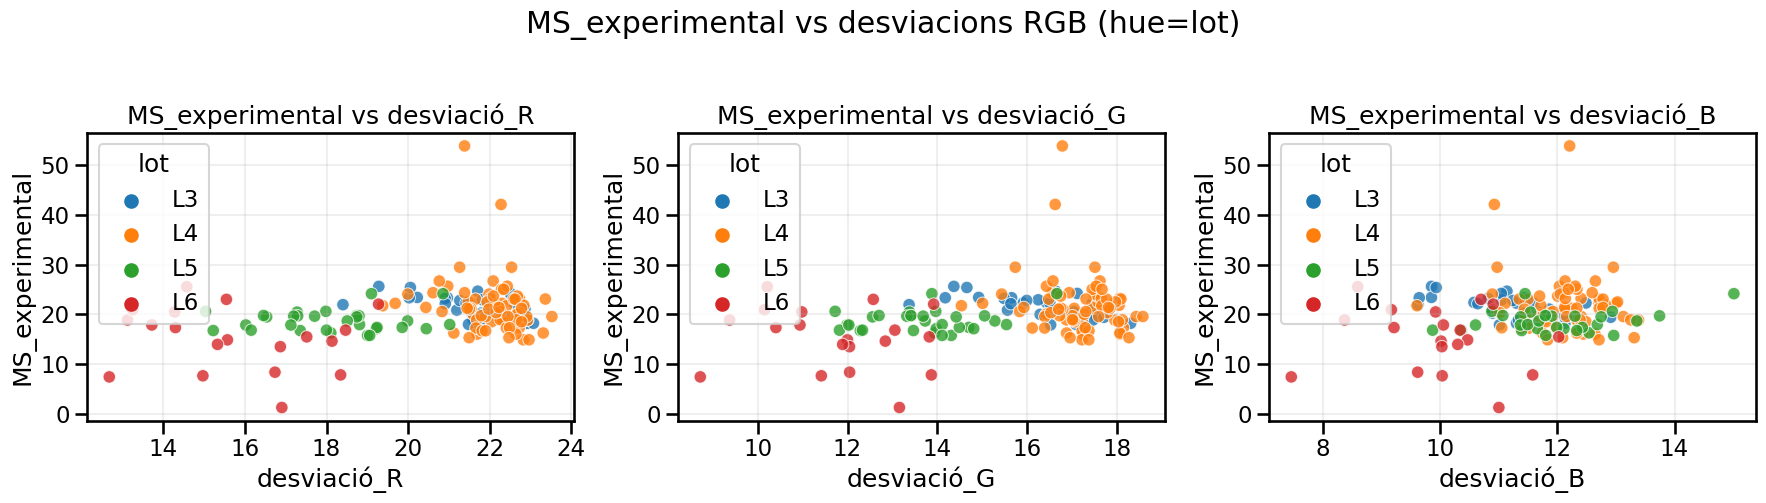

✅ Figura guardada: D:\potato-dry-matter-optics-ml\data\output\study\study_definitive\ms_vs_y1y2_norm.png


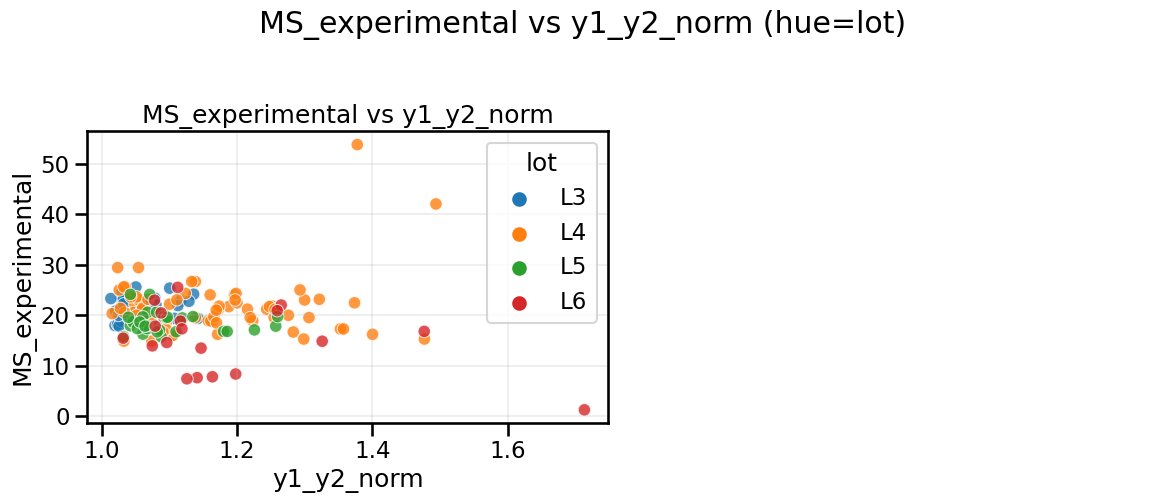

✅ Figura guardada: D:\potato-dry-matter-optics-ml\data\output\study\study_definitive\ms_vs_canal_NIR.png


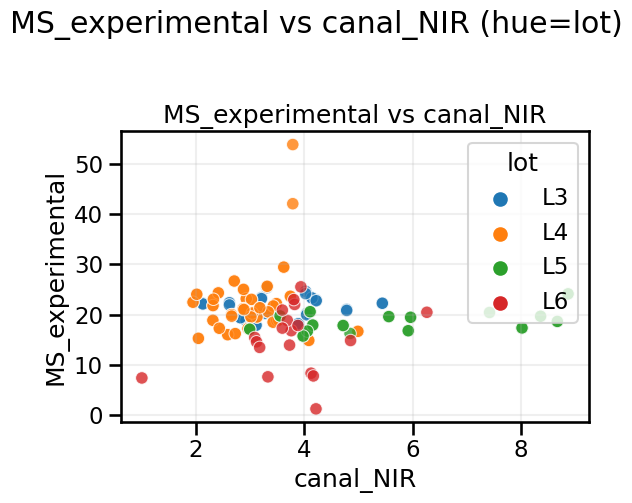

In [11]:
# Plots: MS_experimental (y) vs features (x), amb color per lot
sns.set_context("talk")

def _scatter_grid(y_col, x_cols, title, filename, ncols):
    nrows = int(np.ceil(len(x_cols) / ncols))
    fig, axes = plt.subplots(nrows, ncols, figsize=(6*ncols, 5*nrows), squeeze=False)
    for i, x in enumerate(x_cols):
        r, c = divmod(i, ncols)
        ax = axes[r][c]
        sns.scatterplot(data=df_final.reset_index(), x=x, y=y_col, hue="lot", ax=ax, alpha=0.8)
        ax.set_title(f"{y_col} vs {x}")
        ax.grid(True, alpha=0.2)
    # Apagar axes buits
    for j in range(len(x_cols), nrows*ncols):
        r, c = divmod(j, ncols)
        axes[r][c].axis("off")
    fig.suptitle(title, y=1.02)
    fig.tight_layout()
    out = FIG_DIR / filename
    fig.savefig(out, dpi=200, bbox_inches="tight")
    print(f"✅ Figura guardada: {out}")
    plt.show()

# 3 en línia (colors promig)
_scatter_grid(
    y_col="MS_experimental",
    x_cols=["color_promig_R", "color_promig_G", "color_promig_B"],
    title="MS_experimental vs colors_promig (hue=lot)",
    filename="ms_vs_colors_promig.png",
    ncols=3,
)

# 3 en línia (desviacions)
_scatter_grid(
    y_col="MS_experimental",
    x_cols=["desviació_R", "desviació_G", "desviació_B"],
    title="MS_experimental vs desviacions RGB (hue=lot)",
    filename="ms_vs_desviacions_rgb.png",
    ncols=3,
)

# 1 plot (y1_y2_norm)
_scatter_grid(
    y_col="MS_experimental",
    x_cols=["y1_y2_norm"],
    title="MS_experimental vs y1_y2_norm (hue=lot)",
    filename="ms_vs_y1y2_norm.png",
    ncols=2,
)

# 1 plot (canal_NIR)
_scatter_grid(
    y_col="MS_experimental",
    x_cols=["canal_NIR"],
    title="MS_experimental vs canal_NIR (hue=lot)",
    filename="ms_vs_canal_NIR.png",
    ncols=1,
)


✅ Figura guardada: D:\potato-dry-matter-optics-ml\data\output\study\study_definitive\densitat_vs_colors_promig.png


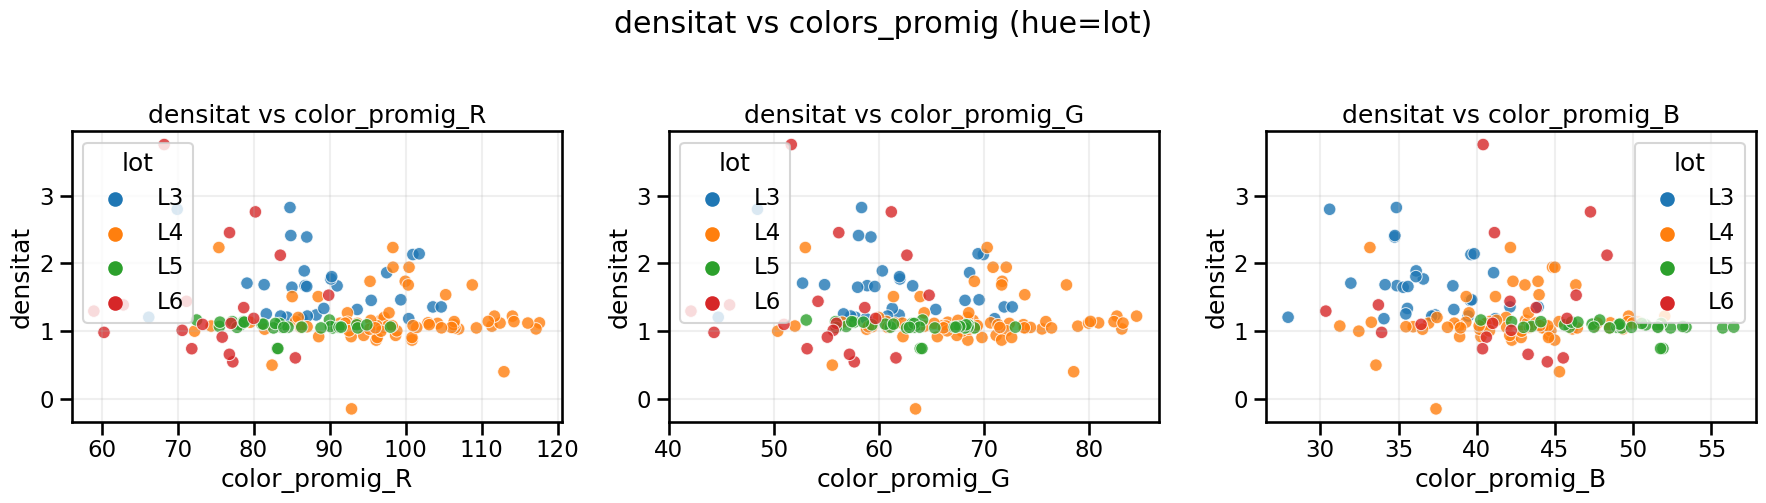

✅ Figura guardada: D:\potato-dry-matter-optics-ml\data\output\study\study_definitive\densitat_vs_desviacions_rgb.png


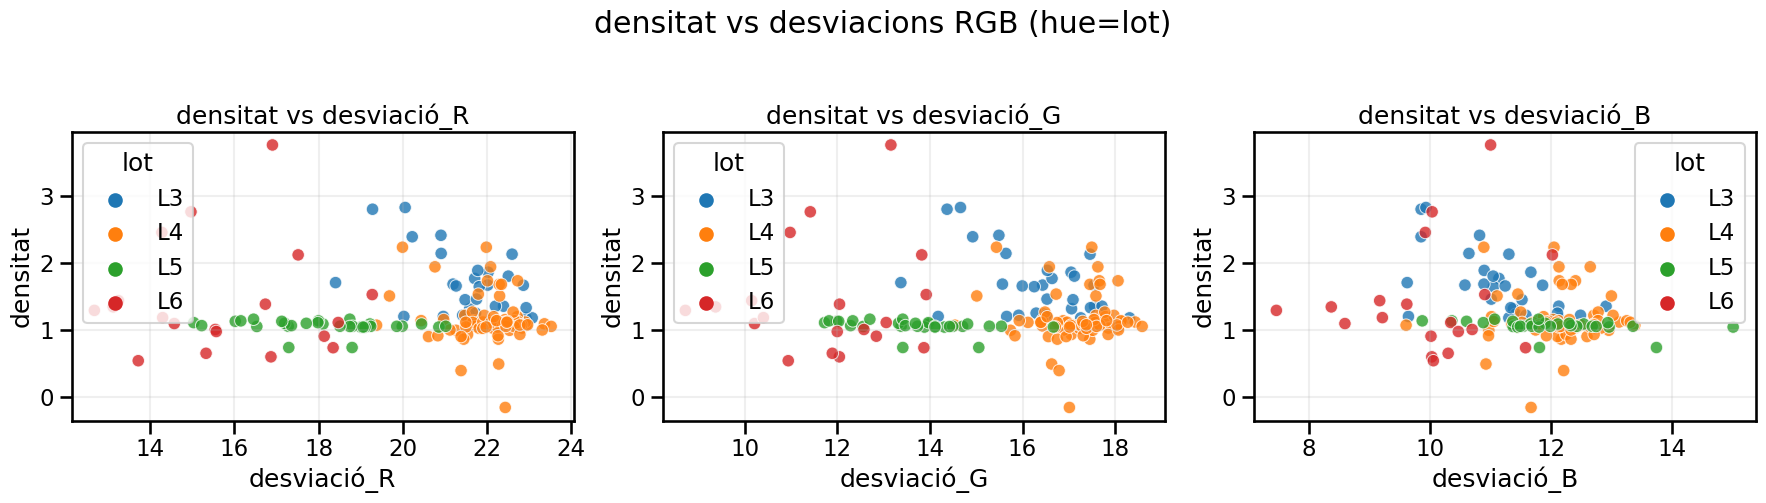

✅ Figura guardada: D:\potato-dry-matter-optics-ml\data\output\study\study_definitive\densitat_vs_y1y2_norm.png


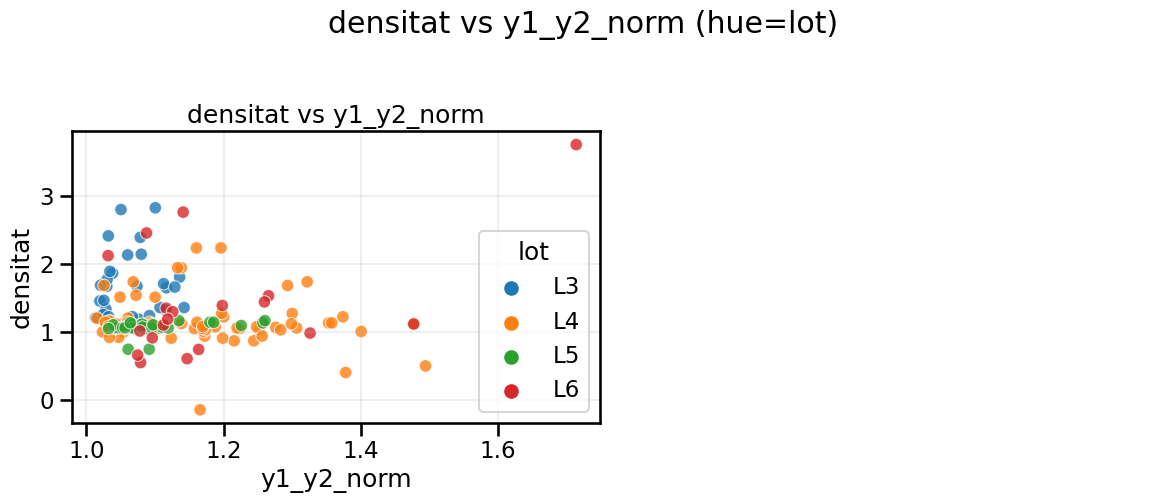

✅ Figura guardada: D:\potato-dry-matter-optics-ml\data\output\study\study_definitive\densitat_vs_canal_NIR.png


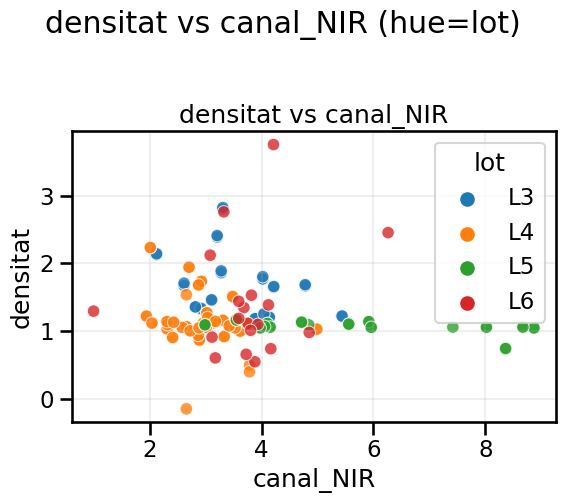

In [12]:
# Plots: densitat (y) vs features (x), amb color per lot
_scatter_grid(
    y_col="densitat",
    x_cols=["color_promig_R", "color_promig_G", "color_promig_B"],
    title="densitat vs colors_promig (hue=lot)",
    filename="densitat_vs_colors_promig.png",
    ncols=3,
)

_scatter_grid(
    y_col="densitat",
    x_cols=["desviació_R", "desviació_G", "desviació_B"],
    title="densitat vs desviacions RGB (hue=lot)",
    filename="densitat_vs_desviacions_rgb.png",
    ncols=3,
)

_scatter_grid(
    y_col="densitat",
    x_cols=["y1_y2_norm"],
    title="densitat vs y1_y2_norm (hue=lot)",
    filename="densitat_vs_y1y2_norm.png",
    ncols=2,
)

_scatter_grid(
    y_col="densitat",
    x_cols=["canal_NIR"],
    title="densitat vs canal_NIR (hue=lot)",
    filename="densitat_vs_canal_NIR.png",
    ncols=1,
)


✅ Figura guardada: D:\potato-dry-matter-optics-ml\data\output\study\study_definitive\ms_vs_densitat.png


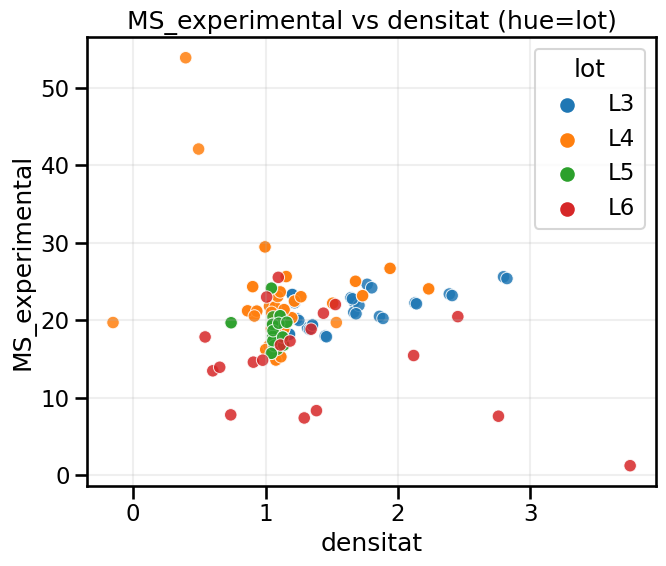

In [13]:
# MS_experimental vs densitat
fig, ax = plt.subplots(figsize=(7,6))
sns.scatterplot(data=df_final.reset_index(), x="densitat", y="MS_experimental", hue="lot", ax=ax, alpha=0.85)
ax.set_title("MS_experimental vs densitat (hue=lot)")
ax.grid(True, alpha=0.2)
fig.tight_layout()

out = FIG_DIR / "ms_vs_densitat.png"
fig.savefig(out, dpi=200, bbox_inches="tight")
print(f"✅ Figura guardada: {out}")
plt.show()


## Extra: Visualització del procès de neteja de la imatge

Mostra: 36
Imatge: D:\potato-dry-matter-optics-ml\data\input\raw\raw_images\definitive\p3_1.png
Color mitjà (RGB) sobre FILTRAT, sense negres: [100.42256194  71.01175748  41.18793632]


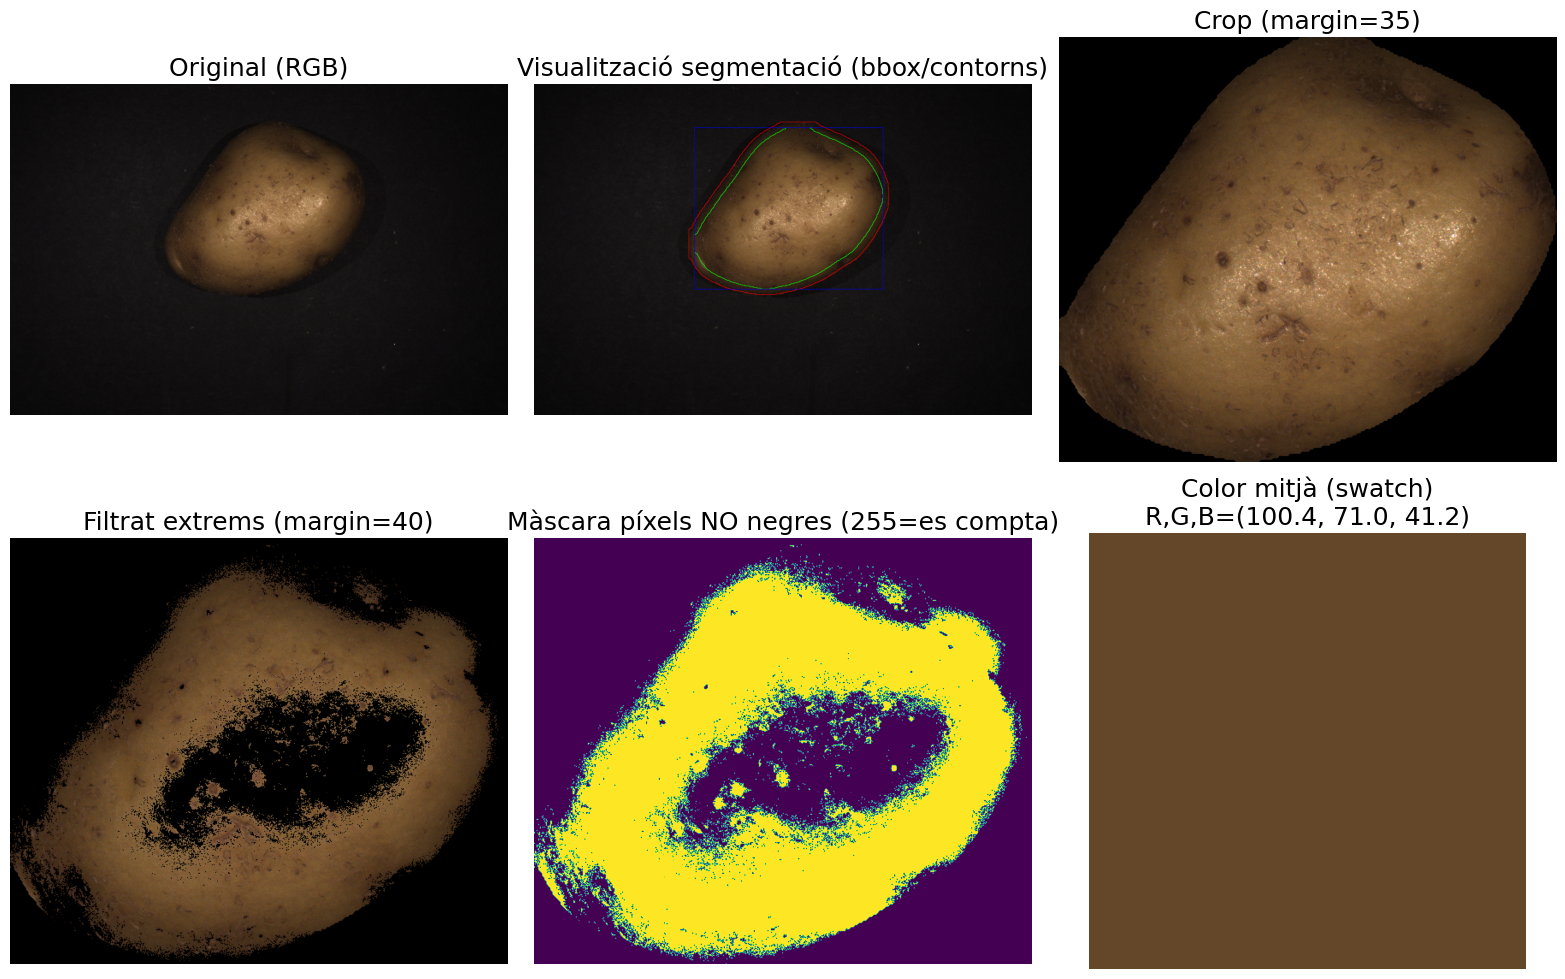

In [15]:
# === DEBUG CELL (es pot borrar) ======================================
# Mostra el pipeline d'una patata: original -> crop -> filtrat + màscara
# i calcula/mostra el color mitjà (només píxels NO negres)

import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image

# Imports de funcions del projecte
try:
    from src.raw_image_treatment import potato_pixels_rgb_img, potato_filter_extreme_colours
except Exception as e:
    raise ImportError(
        "No he pogut importar des de src.raw_image_treatment.\n"
        "Assegura't que estàs executant aquest notebook dins del repo i que existeix src/raw_image_treatment.py\n"
        f"Error original: {e}"
    )

# --- Config -----------------------------------------------------------
SHOW_ID = 36  # posa un int (id_mostra) si vols forçar-ne una, ex: 123
SEGMENT_MARGIN = 35
FILTER_MARGIN  = 40

def show_img(ax, img, title):
    ax.imshow(img)
    ax.set_title(title)
    ax.axis("off")

def rgb_mean_ignore_black(pil_img):
    """Mitjana RGB ignorant píxels negres (0,0,0). Retorna (mean_rgb, mask_uint8_img)."""
    arr = np.asarray(pil_img, dtype=np.uint8)
    if arr.ndim != 3 or arr.shape[2] != 3:
        raise ValueError(f"Imatge RGB esperada, però arr shape={arr.shape}")

    mask = np.any(arr != 0, axis=2)  # True si el píxel NO és negre
    if mask.sum() == 0:
        return (np.array([np.nan, np.nan, np.nan]), None)

    vals = arr[mask]  # (N,3)
    mean = vals.mean(axis=0)  # float
    mask_img = (mask.astype(np.uint8) * 255)
    return mean, Image.fromarray(mask_img)

# --- Tria de mostra ---------------------------------------------------
df_src = df  # o df_final si ho prefereixes
if SHOW_ID is None:
    row = df_src.iloc[0]
    chosen_id = df_src.index[0]
else:
    chosen_id = int(SHOW_ID)
    row = df_src.loc[chosen_id]

ruta_col = "ruta_imatges" if "ruta_imatges" in df_src.columns else ("ruta_images" if "ruta_images" in df_src.columns else None)
if ruta_col is None:
    raise KeyError("No trobo la columna 'ruta_imatges' ni 'ruta_images' al dataframe.")

img_rel = str(row[ruta_col]).strip()
img_path = IMAGES_ROOT / img_rel

print(f"Mostra: {chosen_id}")
print(f"Imatge: {img_path}")

if not img_path.exists():
    raise FileNotFoundError(f"No existeix la imatge: {img_path}")

# --- 1) Original ------------------------------------------------------
orig = Image.open(img_path).convert("RGB")

# --- 2) Crop (segmentació) -------------------------------------------
cropped_img, vis = potato_pixels_rgb_img(img_path, margin=SEGMENT_MARGIN)

# --- 3) Filtrat de colors extrems ------------------------------------
filtered_img = None
if cropped_img is not None:
    filt_out = potato_filter_extreme_colours(cropped_img, margin=FILTER_MARGIN, ignore_black=True)
    filtered_img = filt_out[0] if isinstance(filt_out, tuple) else filt_out

# --- 4) Color mitjà sobre imatge filtrada (ignorant negres) ----------
mean_rgb = np.array([np.nan, np.nan, np.nan])
mask_img = None
mean_swatch = None

if filtered_img is not None:
    mean_rgb, mask_img = rgb_mean_ignore_black(filtered_img)
    # "swatch" (imatge d'un sol color) per visualitzar el color mitjà
    sw = np.ones((80, 80, 3), dtype=np.uint8)
    sw[:] = np.clip(np.round(mean_rgb), 0, 255).astype(np.uint8)
    mean_swatch = Image.fromarray(sw)

print(f"Color mitjà (RGB) sobre FILTRAT, sense negres: {mean_rgb}")

# --- Plot -------------------------------------------------------------
fig, axes = plt.subplots(2, 3, figsize=(16, 10))

show_img(axes[0,0], orig, "Original (RGB)")

if vis is not None:
    show_img(axes[0,1], vis, "Visualització segmentació (bbox/contorns)")
else:
    axes[0,1].axis("off"); axes[0,1].set_title("Visualització segmentació: None")

if cropped_img is not None:
    show_img(axes[0,2], cropped_img, f"Crop (margin={SEGMENT_MARGIN})")
else:
    axes[0,2].axis("off"); axes[0,2].set_title("Crop: None")

if filtered_img is not None:
    show_img(axes[1,0], filtered_img, f"Filtrat extrems (margin={FILTER_MARGIN})")
else:
    axes[1,0].axis("off"); axes[1,0].set_title("Filtrat: None")

if mask_img is not None:
    show_img(axes[1,1], mask_img, "Màscara píxels NO negres (255=es compta)")
else:
    axes[1,1].axis("off"); axes[1,1].set_title("Màscara: None")

if mean_swatch is not None:
    show_img(axes[1,2], mean_swatch, f"Color mitjà (swatch)\nR,G,B={tuple(np.round(mean_rgb,1))}")
else:
    axes[1,2].axis("off"); axes[1,2].set_title("Color mitjà: None")

plt.tight_layout()
plt.show()
# =====================================================================
